In [1]:
%load_ext autoreload

In [30]:
%autoreload

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from astropy.io import fits
import scipy
from scipy.interpolate import interp1d
import math as m
import scipy.constants as p
import pandas as pd
import matplotlib.pyplot as plt
import timeit
import sys
sys.path.append("..")
import physics
sys.path.append("../..")
from spec.spectrum import *
import spec.spectools as spectools
#%run 'Electrons_v1.ipynb' might need things form this later
import xsecs
np.set_printoptions(precision=20)

In [19]:
class Rates(object):
    '''
    Allows for easier storage of all xsecs/rates (probabilities)
    Made specifically for ion and heating ONLY.
    
    Attributes
    -----------
    E_spec : Spectrum class
        Electron energy and dNdE spectrum
    n : int
        The bin of interest in the spectrum
    den : ndarray
        density of [H, He, He+] in cm^-3
    rates : dN/dt; Filled with various rates in s^-1
    '''
    
    def __init__(self, E_spec, n, den=[1,1,1], rates=np.zeros(4), dNdW=np.zeros((2,1))):
        '''Return a Rate object with electron of energy *E_spec.eng[n]*
        in a universe with densities *den*; initializes *rate* vector'''
        self.energy = E_spec.eng[n]
        self.n = n
        self.dNdE = E_spec.dNdE[n]
        self.den = den
        self.rates = rates
        self.v = np.sqrt(2*np.array([E_spec.eng[n]])/physics.me)*physics.c 
        self.mult = self.den*self.v
        self.dNdW = np.resize(dNdW,(2, self.n -1))
    
    def ion_dNdW_calc(self):
        '''Fills *self.dNdW[0,:] with the discretized singly differential xsec in rate form
        '''
        def H_ion_dNdE_at_W(test_energy):
            return xsecs.ionize_s_cs(self.energy*np.ones(1),test_energy*np.ones(1),np.ones(1))[0]
        
        eng_temp = E_spec.eng[0:self.n-1]
        ion_s_rates = spectools.discretize(eng_temp, H_ion_dNdE_at_W)
        self.dNdW[0] = ion_s_rates.dNdE *self.mult[0]
        return self.dNdW
    
    def ionize_s_cs_He(self): #TEST/not for future use without modification
        '''helium secondaries
        '''
        eng_temp = E_spec.eng[0:self.n]
        ion_s_rates = xsecs.ionize_s_cs(self.energy*np.ones(self.n),eng_temp,2*np.ones(self.n))
        self.He = ion_s_rates
        return self.He
        
    
    def ion_rate_calc(self):
        '''Fills *self.rate[1:3]* vector by calculating xsec and then converting to rate
        '''
        ion_rates = xsecs.ionize_cs(self.energy*np.ones(3),np.array([1,2,3]))*self.mult
        self.rates[1:4] = ion_rates
        return self.rates
    
    def heat_rate_calc(self, x_e, rs):
        '''Fills *self.rate[0]* vector with fraction going to heating
            x_e and rs...
        '''
        dE = xsecs.heating_dE(self.energy, x_e, rs, nH=physics.nH)
        delta_dNdE = np.zeros(len(E_spec.dNdE))
        np.put(delta_dNdE, self.n, self.dNdE)
        delta = Spectrum(E_spec.eng, delta_dNdE, rs)
        shift_delta_eng = E_spec.eng+dE
        delta.shift_eng(shift_delta_eng)
        delta.rebin(E_spec.eng)
        
        heating_frac = delta.dNdE[self.n]/self.dNdE
        self.rates[0] = 1-heating_frac
        return(self.rates)
    def tot_sum(self):
        '''Sums all elements of rate
        '''
        tot_sum = sum(self.rates)
        return tot_sum
    def con_prob(self):
        '''Finds cumulative probability of each process
        '''
        con_prob = self.rates/self.tot_sum()
        return con_prob
    def E_loss(self):
        '''loss fraction
        '''
        E_loss_ion=13.6*self.rates[1]
        E_loss_heat=(E_spec.eng[self.n]-E_spec.eng[self.n-1])*self.rates[0]
        E_frac = E_loss_ion/E_loss_heat
        return(E_frac)
    def ion_int_calc(self):
        '''gives total ionization rate
        '''
        bin_width = get_log_bin_width(E_spec.eng[0:self.n])
        integ = 0
        for i in range(self.n):
            integ += self.dNdW[0,i-1]*bin_width[i]*E_spec.eng[i]
        return integ
        
        

In [15]:
eng1 = np.logspace(0.,4.,num = 500)
dNdE1 = np.logspace(0.,5.,num = 500)
rs=1000
E_spec = Spectrum(eng1,dNdE1,rs)
photon_spec = Spectrum(E_spec.eng,np.zeros(len(E_spec.eng)),rs)
TM=np.zeros([len(photon_spec.eng)+2,len(E_spec.eng)]) #possibly make pandas
Transfer_Matrix=pd.DataFrame(TM) #or np.zeros
#print(Transfer_Matrix)
print(np.array([E_spec.eng[330]]))
print(xsecs.ionize_cs(np.array([E_spec.eng[100]]),np.ones(1)))

[ 441.86599563859414274702]
[ 0.]


In [20]:
a = Rates(E_spec, 300)
# print(a.dNdW)
print(a.ion_dNdW_calc())
print(a.dNdW)
print(a.ion_int_calc())
print(a.energy)
print(a.ion_rate_calc())
# print(a.heat_rate_calc(0.0001, 300))
# print(a.tot_sum())
# print(a.con_prob())
# print(a.rates)


[[  1.36295201878502423024e-13   2.68760350834057064291e-13
    2.66760002818351129415e-13   2.64755226180559293851e-13
    2.62746114871217323967e-13   2.60732760778566332124e-13
    2.58715253811608041257e-13   2.56693681994036888864e-13
    2.54668131569250666352e-13   2.52638687116003990094e-13
    2.50605431674947800535e-13   2.48568446885589499296e-13
    2.46527813133668473597e-13   2.44483609708604806467e-13
    2.42435914970816144626e-13   2.40384806528631557842e-13
    2.38330361424411670103e-13   2.36272656329549925710e-13
    2.34211767748056460056e-13   2.32147772228121961119e-13
    2.30080746581425141054e-13   2.28010768109556212776e-13
    2.25937914837138944218e-13   2.23862265751121049499e-13
    2.21783901045593169760e-13   2.19702902371721565930e-13
    2.17619353092011039390e-13   2.15533338538427465062e-13
    2.13444946273626139300e-13   2.11354266354704255483e-13
    2.09261391598665321374e-13   2.07166417849191444744e-13
    2.05069444243475446211e-13   2.02970

In [ ]:
scipy.integrate.quad()

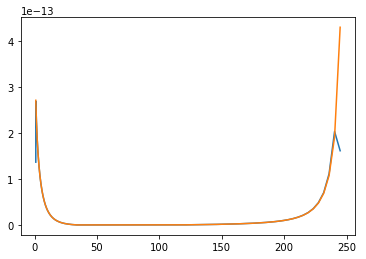

In [29]:
x_test = E_spec.eng[0:299]
y_test_1 = a.dNdW[0]
y_test_2 = xsecs.ionize_s_cs(E_spec.eng[300]*np.ones(300),x_test,np.ones(300))*a.mult[0]
plt.plot(x_test, y_test_1, 'r')
#plt.plot(x_test, y_test_2, 'b')
plt.show()

In [7]:
def electron_low_e(E_spec, rs, ion_frac=[10**-4,10**-4,10**-4], den=[1,1,1], dt=1, photon_abscissa=E_spec.eng ,all_outputs=False):
    '''
    Finds transfer matrix for a given initial electron spectrum
    Outputs: photon spectrum, transfer matrix, E_loss to each process
    '''
    #Initialize photon spectrum
    #photon_spec = Spectrum(photon_abscissa,np.zeros(len(E_spec.eng)),rs)
    
    #calculate non-ionized atomic densities
    den[0]=(physics.nH*(1-ion_frac[0]))*(rs)**3
    den[1]=(physics.nHe*(1-ion_frac[1])*(1-ion_frac[2]))*(rs)**3
    den[2]=(physics.nHe*(1-ion_frac[1])*(ion_frac[2]))*(rs)**3 #unsure about how ionfrac works for helium
    
    #ndarray of fractions to heating, ion (H,He,He+)
    frac_table=np.zeros((4,len(E_spec.eng)))
    
    for n in range(len(E_spec.eng)):
        e_rates = Rates(E_spec, n, den=den)
        e_rates.ion_rate_calc()
        e_rates.heat_rate_calc(ion_frac[1], rs)
            #print(e_rates.energy) print(e_rates.rates) print(e_rates.E_loss())
        ## discrete_dN_dEdt_i = spectools.discretize(xsecs.ionize_s_cs, e_rates.eng)
    
    

In [8]:
electron_low_e(E_spec,100)

ValueError: need at least one array to concatenate